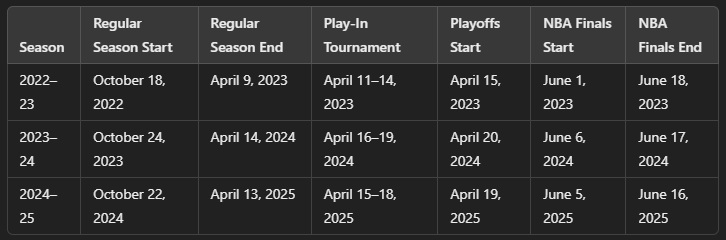

In [5]:
%load_ext autoreload
%autoreload 2

import os
import re
import sys

sys.path.append(os.path.abspath("../"))

import faiss
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from src.data_utils import create_training_dataset
from src.model_xg import train_and_plot
from src.utils import compute_auc_roc, evaluate_prediction

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 400)


load_dotenv()

from src.data_utils import PodcastContainer, load_clean_scores
from src.player_utils import PlayerUtil
from src.utils import get_repo_root

seasons = ["2023-24"]
scores = load_clean_scores(seasons)
player_util = PlayerUtil(seasons=seasons)
pod_container = PodcastContainer()

# scores['outperform_next'] = scores.groupby('personId')['outperformed'].shift(-1)
scores.head(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,outperform_next,outperform_next_5,outperform_next_10,injured_next,injured,fantasyDiff
390948,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,2544,lebron james,29.016667,10,16,0.625,1,4,0.25,0,1,0.0,1,7,8,5,1,0,0,1,21,7,40.50,49.35,0,1,False,False,0.0,0,-8.85
390949,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,11.60,0,0,False,False,1.0,1,-11.60
390950,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,202704,reggie jackson,24.066667,3,8,0.375,2,5,0.40,0,0,0.0,0,3,3,1,1,0,2,0,8,11,14.25,19.10,0,1,True,False,0.0,0,-4.85
390951,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,203076,anthony davis,34.150000,6,17,0.353,1,2,0.50,4,4,1.0,1,7,8,4,0,2,2,3,17,-17,36.00,51.80,0,1,True,True,0.0,0,-15.80
390952,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,203200,justin holiday,0.000000,0,0,0.000,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,8.20,0,0,False,False,1.0,1,-8.20


In [8]:
pdc = pod_container.get_all_episodes()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


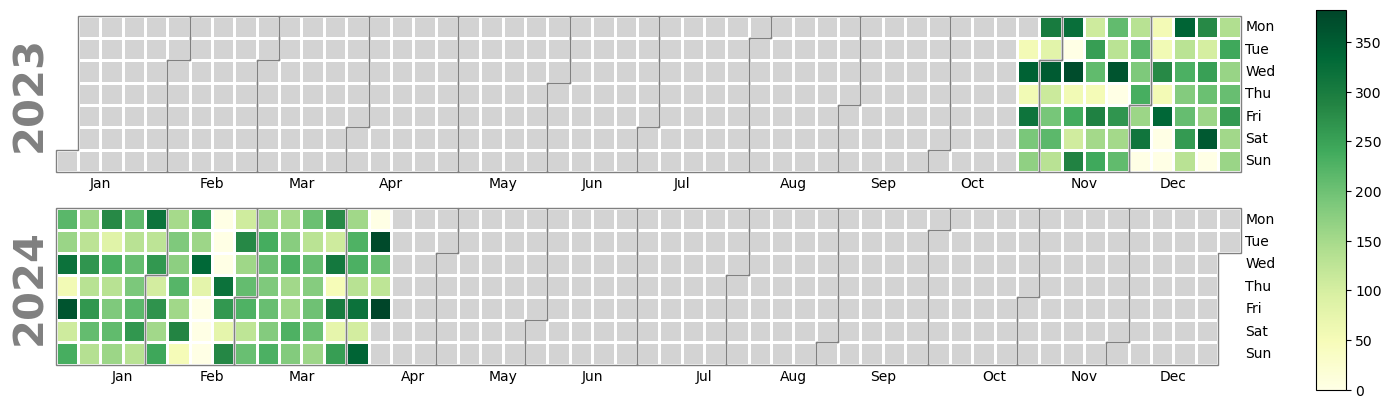

In [18]:
import pandas as pd
import calplot
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import calplot

def create_calendar_heatmap(date_series, title="Calendar Heatmap"):
    """
    Create a GitHub-style calendar heatmap from a pandas Series of dates.

    Parameters:
        date_series (pd.Series): A pandas Series containing dates. The values can be counts or frequencies.
                                 If values are not provided, each date will be counted as 1.
        title (str): Title for the heatmap. Defaults to "Calendar Heatmap".

    Returns:
        None: Displays the heatmap.
    """
    # Ensure input is a pandas Series
    if not isinstance(date_series, pd.Series):
        raise ValueError("Input must be a pandas Series.")

    # Convert to datetime if necessary
    if not pd.api.types.is_datetime64_any_dtype(date_series.index):
        try:
            date_series.index = pd.to_datetime(date_series.index)
        except Exception as e:
            raise ValueError("The index of the Series must be convertible to datetime.") from e

    # If values are missing, count occurrences of each date
    if date_series.empty or not np.issubdtype(date_series.values.dtype, np.number):
        date_series = date_series.value_counts()
        date_series.sort_index(inplace=True)

    # Ensure the data is daily
    date_series = date_series.resample('D').sum()

    # Plot the calendar heatmap
    calplot.calplot(
        date_series,
        cmap='YlGn',
        colorbar=True,
        figsize=(15, 4),
        fillcolor='lightgray'
    )


# create_calendar_heatmap(pdc.publication_date)
create_calendar_heatmap(scores.game_date)



In [12]:
stats = player_util.player_minute_stats().sort_values("avg_minutes_per_game", ascending=False)
stats['total_time'] = stats['total_games'] * stats['avg_minutes_per_game']

stats

,season_year,personId,personName,avg_minutes_per_game,games_over_5_minutes,total_games,total_time
227,2023-24,1629029,luka doncic,37.486667,70,70,2624.066667
21,2023-24,201942,demar derozan,37.357500,79,80,2988.600000
144,2023-24,1627832,fred vanvleet,36.773288,73,73,2684.450000
4,2023-24,201142,kevin durant,36.718421,75,76,2790.600000
256,2023-24,1629632,coby white,36.473207,79,79,2881.383333
...,...,...,...,...,...,...,...
564,2023-24,1641777,charles bediako,0.000000,0,1,0.000000
581,2023-24,1641936,miles norris,0.000000,0,1,0.000000
582,2023-24,1641945,jaylin galloway,0.000000,0,3,0.000000
218,2023-24,1629015,zhaire smith,0.000000,0,3,0.000000


In [29]:
s = stats[stats.total_time > 1000].sort_values('personName')

# s.sort_values('total_time', ascending=True)

for person in s.personName.unique():
    print(person)

aaron gordon
aaron holiday
aaron nesmith
aaron wiggins
al horford
alec burks
alex caruso
alperen sengun
amen thompson
amir coffey
andre drummond
andrew nembhard
andrew wiggins
anfernee simons
anthony black
anthony davis
anthony edwards
ausar thompson
austin reaves
ayo dosunmu
bam adebayo
bennedict mathurin
bilal coulibaly
bobby portis
bogdan bogdanovic
bojan bogdanovic
bradley beal
brandin podziemski
brandon ingram
brandon miller
brook lopez
bruce brown
buddy hield
cade cunningham
caleb martin
cam thomas
cameron johnson
cameron payne
caris levert
cason wallace
cedi osman
chet holmgren
chris paul
christian braun
cj mccollum
clint capela
coby white
cole anthony
collin sexton
corey kispert
d'angelo russell
dalano banton
damian lillard
daniel gafford
daniel theis
dante exum
dario saric
darius garland
david roddy
davion mitchell
de'aaron fox
de'andre hunter
de'anthony melton
dean wade
deandre ayton
dejounte murray
demar derozan
deni avdija
dennis schroder
dennis smith jr
dereck lively ii
de

In [4]:
stats[stats.personId == 1628369]

,season_year,personId,personName,avg_minutes_per_game,games_over_5_minutes,total_games
257,2020-21,1628369,jayson tatum,34.692929,64,66
784,2021-22,1628369,jayson tatum,35.933991,76,76
1346,2022-23,1628369,jayson tatum,36.921622,74,74
1863,2023-24,1628369,jayson tatum,35.270000,74,75


In [5]:
player_util.players_for_date('2023-12-22').head(10)

,personId,personName,teamName
402992,201152,thaddeus young,raptors
402993,201976,patrick beverley,76ers
402994,202066,garrett temple,raptors
402995,202694,marcus morris sr,76ers
402996,202699,tobias harris,76ers
402997,203471,dennis schroder,raptors
402998,203490,otto porter jr,raptors
402999,203496,robert covington,76ers
403000,203954,joel embiid,76ers
403001,1626162,kelly oubre jr,76ers


In [6]:
player_util.players_for_date('2023-12-22').head(10)
player_util.players_for_date_range('2023-12-22', '2023-12-24').head(10)

,personId,personName,teamName
402992,201152,thaddeus young,raptors
402993,201976,patrick beverley,76ers
402994,202066,garrett temple,raptors
402995,202694,marcus morris sr,76ers
402996,202699,tobias harris,76ers
402997,203471,dennis schroder,raptors
402998,203490,otto porter jr,raptors
402999,203496,robert covington,76ers
403000,203954,joel embiid,76ers
403001,1626162,kelly oubre jr,76ers


## Baseline XG Boost Model

In [7]:
from sklearn.model_selection import train_test_split
from src.model_xg import add_lagged_features
from xgboost import XGBRegressor

lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]

df_xg, new_feats = add_lagged_features(df, lag_features, 5)
df_xg = df_xg.dropna()

# ---- Create train/test dataset ----
select_features = ["plusMinusPoints"] + new_feats
target_col = "fantasyPoints"

train_size = int(len(df) * 0.8)
train_df = df_xg.iloc[train_size:]
test_df = df_xg.iloc[:train_size]

X_train, X_test = train_df[select_features], test_df[select_features]
y_train, y_test = train_df[target_col], test_df[target_col]

# ---- Train XGBoost model ----
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# ---- Evaluate the model ----
y_pred = model.predict(X_test)

display(df_xg)

# 5-day moving average performance
print(
    "Sliding Window MAE:", np.mean(np.abs(y_test - test_df["projectedFantasyPoints"]))
)
print("Model MAE:", np.mean(np.abs(y_test - y_pred)))

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,minutes_lag_1,minutes_lag_2,minutes_lag_3,minutes_lag_4,minutes_lag_5,fieldGoalsAttempted_lag_1,fieldGoalsAttempted_lag_2,fieldGoalsAttempted_lag_3,fieldGoalsAttempted_lag_4,fieldGoalsAttempted_lag_5,fieldGoalsPercentage_lag_1,fieldGoalsPercentage_lag_2,fieldGoalsPercentage_lag_3,fieldGoalsPercentage_lag_4,fieldGoalsPercentage_lag_5,threePointersAttempted_lag_1,threePointersAttempted_lag_2,threePointersAttempted_lag_3,threePointersAttempted_lag_4,...,freeThrowsAttempted_lag_1,freeThrowsAttempted_lag_2,freeThrowsAttempted_lag_3,freeThrowsAttempted_lag_4,freeThrowsAttempted_lag_5,freeThrowsPercentage_lag_1,freeThrowsPercentage_lag_2,freeThrowsPercentage_lag_3,freeThrowsPercentage_lag_4,freeThrowsPercentage_lag_5,reboundsDefensive_lag_1,reboundsDefensive_lag_2,reboundsDefensive_lag_3,reboundsDefensive_lag_4,reboundsDefensive_lag_5,reboundsTotal_lag_1,reboundsTotal_lag_2,reboundsTotal_lag_3,reboundsTotal_lag_4,reboundsTotal_lag_5,assists_lag_1,assists_lag_2,assists_lag_3,assists_lag_4,assists_lag_5,steals_lag_1,steals_lag_2,steals_lag_3,steals_lag_4,steals_lag_5,blocks_lag_1,blocks_lag_2,blocks_lag_3,blocks_lag_4,blocks_lag_5,turnovers_lag_1,turnovers_lag_2,turnovers_lag_3,turnovers_lag_4,turnovers_lag_5,foulsPersonal_lag_1,foulsPersonal_lag_2,foulsPersonal_lag_3,foulsPersonal_lag_4,foulsPersonal_lag_5,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5
302252,2020-21,2021-01-01,22000070,BOS @ DET,celtics,celtics,201952,jeff teague,20.150000,4,5,0.800,1,1,1.000,3,4,0.75,0,1,1,3,2,0,1,3,12,5,21.25,19.60,True,21.333333,19.100000,21.850000,21.300000,25.000000,6.0,7.0,6.0,5.0,15.0,0.333,0.286,0.000,0.000,0.467,2.0,3.0,0.0,1.0,...,0.0,0.0,10.0,0.0,2.0,0.000,0.0,0.9,0.000,0.50,5.0,2.0,3.0,1.0,1.0,5.0,2.0,3.0,1.0,3.0,4.0,2.0,2.0,2.0,4.0,4.0,1.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,3.0,2.0,1.0,1.0,4.0,6.0,9.0,0.0,19.0
302258,2020-21,2021-01-01,22000070,BOS @ DET,celtics,celtics,203935,marcus smart,38.183333,5,14,0.357,3,6,0.500,0,3,0.00,0,3,3,9,3,0,4,3,13,-1,34.25,27.00,True,26.316667,31.733333,31.633333,31.883333,38.450000,11.0,10.0,8.0,12.0,3.0,0.455,0.300,0.500,0.333,0.000,9.0,6.0,4.0,7.0,...,0.0,10.0,2.0,2.0,4.0,0.000,0.8,0.5,1.000,0.75,2.0,0.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,1.0,4.0,5.0,6.0,6.0,7.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,5.0,2.0,14.0,17.0,11.0,13.0,3.0
302261,2020-21,2021-01-01,22000070,BOS @ DET,celtics,celtics,1627759,jaylen brown,37.566667,12,21,0.571,1,7,0.143,0,0,0.00,2,7,9,2,3,2,4,3,25,-9,47.25,42.50,True,28.950000,34.366667,33.616667,30.516667,37.633333,21.0,13.0,13.0,25.0,24.0,0.714,0.538,0.615,0.440,0.542,10.0,2.0,1.0,4.0,...,6.0,10.0,2.0,9.0,4.0,0.833,0.5,1.0,0.556,1.00,4.0,2.0,2.0,3.0,5.0,5.0,2.0,2.0,8.0,5.0,4.0,2.0,4.0,3.0,4.0,1.0,4.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0,1.0,2.0,4.0,5.0,3.0,42.0,20.0,18.0,27.0,33.0
302263,2020-21,2021-01-01,22000070,BOS @ DET,celtics,celtics,1628369,jayson tatum,37.066667,11,24,0.458,3,11,0.273,3,5,0.60,0,6,6,2,1,1,3,1,28,4,41.00,41.85,False,23.250000,40.450000,35.783333,36.116667,32.816667,12.0,17.0,21.0,22.0,28.0,0.500,0.529,0.429,0.409,0.429,5.0,3.0,9.0,6.0,...,1.0,10.0,4.0,0.0,0.0,1.000,0.8,1.0,0.000,0.00,4.0,11.0,11.0,7.0,7.0,4.0,11.0,11.0,8.0,7.0,3.0,4.0,5.0,2.0,2.0,1.0,3.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,5.0,3.0,2.0,0.0,1.0,1.0,1.0,2.0,16.0,27.0,25.0,20.0,30.0
302264,2020-21,2021-01-01,22000070,BOS @ DET,celtics,celtics,1628400,semi ojeleye,6.283333,0,0,0.000,0,0,0.000,0,0,0.00,0,1,1,0,0,0,0,0,0,0,1.25,6.65,False,12.166667,0.000000,12.416667,14.283333,18.983333,

Sliding Window MAE: 7.437996172634336
Model MAE: 6.374908655299193


### Analyze Results

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,xg_predict,xg_outperform
302252,2020-21,2021-01-01,22000070,BOS @ DET,celtics,celtics,201952,jeff teague,20.150000,4,5,0.800,1,1,1.000,3,4,0.75,0,1,1,3,2,0,1,3,12,5,21.25,19.60,True,16.476219,False
302258,2020-21,2021-01-01,22000070,BOS @ DET,celtics,celtics,203935,marcus smart,38.183333,5,14,0.357,3,6,0.500,0,3,0.00,0,3,3,9,3,0,4,3,13,-1,34.25,27.00,True,24.054335,False
302261,2020-21,2021-01-01,22000070,BOS @ DET,celtics,celtics,1627759,jaylen brown,37.566667,12,21,0.571,1,7,0.143,0,0,0.00,2,7,9,2,3,2,4,3,25,-9,47.25,42.50,True,36.911407,False
302263,2020-21,2021-01-01,22000070,BOS @ DET,celtics,celtics,1628369,jayson tatum,37.066667,11,24,0.458,3,11,0.273,3,5,0.60,0,6,6,2,1,1,3,1,28,4,41.00,41.85,False,40.346416,False
302264,2020-21,2021-01-01,22000070,BOS @ DET,celtics,celtics,1628400,semi ojeleye,6.283333,0,0,0.000,0,0,0.000,0,0,0.00,0,1,1,0,0,0,0,0,0,0,1.25,6.65,False,2.190144,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403894,2023-24,2023-12-27,22300415,PHI @ ORL,76ers,sixers,1626162,kelly oubre jr,28.666667,1,7,0.143,1,4,0.250,1,2,0.50,1,3,4,1,2,2,1,1,4,16,18.00,19.35,False,26.259996,True
403895,2023-24,2023-12-27,22300415,PHI @ ORL,76ers,sixers,1627788,furkan korkmaz,0.000000,0,0,0.000,0,0,0.000,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.95,False,-0.181169,False
403896,2023-24,2023-12-27,22300415,PHI @ ORL,76ers,sixers,1627863,danuel house jr,7.166667,0,0,0.000,0,0,0.000,0,0,0.00,1,0,1,0,0,0,1,0,0,1,0.75,5.15,False,9.228760,True
403897,2023-24,2023-12-27,22300415,PHI @ ORL,76ers,sixers,1628964,mo bamba,16.300000,0,1,0.000,0,0,0.000,0,0,0.00,2,5,7,1,1,1,1,2,0,13,13.75,10.35,True,19.824884,True


AUC: 0.6954155841562465


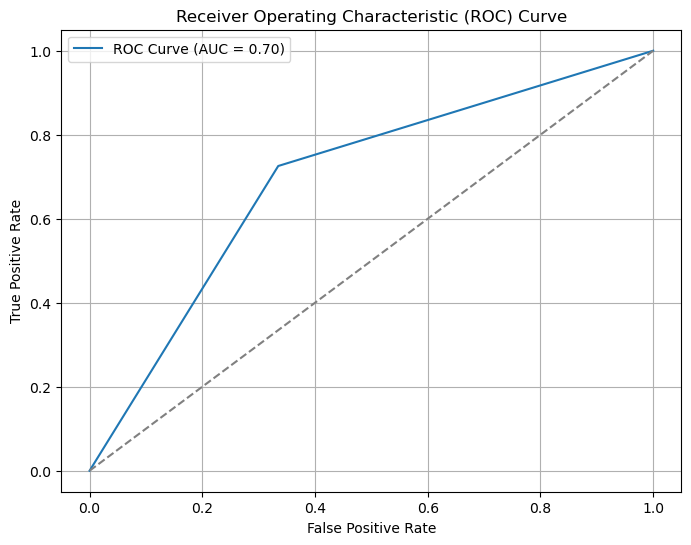

,Feature,Importance
1,minutes_lag_1,0.242795
6,fieldGoalsAttempted_lag_1,0.086676
2,minutes_lag_2,0.060074
3,minutes_lag_3,0.043665
72,points_lag_2,0.038548
7,fieldGoalsAttempted_lag_2,0.034977
9,fieldGoalsAttempted_lag_4,0.032842
8,fieldGoalsAttempted_lag_3,0.029164
10,fieldGoalsAttempted_lag_5,0.027073
75,points_lag_5,0.024932


In [8]:
from src.utils import compute_auc_roc

pattern = r".*_lag_\d+"
columns_to_drop = [col for col in df_xg.columns if re.match(pattern, col)]

results = test_df.drop(columns=columns_to_drop)
results = results.assign(xg_predict=y_pred)
results = results.assign(
    xg_outperform=results["xg_predict"] > results["projectedFantasyPoints"]
)

display(results)


true_labels = results["outperformed"]
predicted_labels = results["xg_outperform"]
auc = compute_auc_roc(true_labels, predicted_labels)

# ---- Extract feature importance scores ----
feature_importances = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)


display(importance_df.head(20))

In [9]:
---

SyntaxError: invalid syntax (1947214667.py, line 1)

## LSTM

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

dfl = df.copy()

# Prepare the data
dfl = dfl.sort_values(
    by=["personId", "game_date"]
)  # Ensure chronological order for sequences

# Normalize the data
scaler = MinMaxScaler()
features = [
    "plusMinusPoints",
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "fantasyPoints"

dfl_scaled = dfl.copy()
dfl_scaled[features + [target_col]] = scaler.fit_transform(
    dfl_scaled[features + [target_col]]
)

train_size = int(len(dfl_scaled) * 0.8)
train_df = dfl_scaled.iloc[train_size:]
test_df = dfl_scaled.iloc[:train_size]
test_df_og = dfl.iloc[:train_size]

In [ ]:
# Function to create sequences
def create_sequences(df, features, target_col, lookback=5):
    sequences = []
    targets = []
    player_ids = df["personId"].unique()

    for player_id in player_ids:
        player_data = df[df["personId"] == player_id]
        feature_data = player_data[features].values
        target_data = player_data[target_col].values

        for i in range(len(feature_data) - lookback):
            seq = feature_data[i : i + lookback]
            target = target_data[i + lookback]
            sequences.append(seq)
            targets.append(target)

    return np.array(sequences), np.array(targets)


# Prepare sequences with adjusted indices
def create_sequences_with_indices(df, features, target_col, lookback=5):
    sequences = []
    targets = []
    indices = []
    player_ids = df["personId"].unique()

    for player_id in player_ids:
        player_data = df[df["personId"] == player_id].reset_index(drop=True)
        feature_data = player_data[features].values
        target_data = player_data[target_col].values

        for i in range(len(feature_data) - lookback):
            seq = feature_data[i : i + lookback]
            target = target_data[i + lookback]
            sequences.append(seq)
            targets.append(target)
            indices.append(player_data.loc[i + lookback, "adjusted_index"])

    return np.array(sequences), np.array(targets), indices

lookback = 5

# Add an index column to test_df for alignment
train_df = train_df.reset_index(drop=True)
train_df["adjusted_index"] = train_df.groupby("personId").cumcount()

# Add an index column to test_df for alignment
test_df = test_df.reset_index(drop=True)
test_df["adjusted_index"] = test_df.groupby("personId").cumcount()

# Create sequences with adjusted indices for test data
X_train, y_train, _ = create_sequences_with_indices(
    train_df, features, target_col, lookback
)
X_test, y_test, test_indices = create_sequences_with_indices(
    test_df, features, target_col, lookback
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass through LSTM layer
        lstm_out, _ = self.lstm(x)
        # Use the last hidden state for prediction
        out = self.fc(lstm_out[:, -1, :])
        return out


# Model parameters
input_size = len(features)  # Number of features
hidden_size = 50  # Number of LSTM hidden units
output_size = 1  # Regression target

model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 20
batch_size = 32

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i : i + batch_size]
        y_batch = y_train[i : i + batch_size]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(X_train):.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    test_loss = criterion(y_pred, y_test).item()
    print(f"Test Loss (MSE): {test_loss:.4f}")
    print(f"Test MAE: {torch.mean(torch.abs(y_pred - y_test)).item():.4f}")

In [ ]:
y_pred_rescaled = scaler.inverse_transform(
    np.hstack(
        (np.zeros((len(y_pred), len(features))), y_pred.cpu().numpy().reshape(-1, 1))
    )
)[:, -1]

results = test_df_og.reset_index(drop=True).merge(
    pd.Series(y_pred_rescaled, name="predicted", index=test_indices),
    left_index=True,
    right_index=True,
    how="inner",
)

results = results.assign(
    predicted_outperform=results["predicted"] > results["projectedFantasyPoints"]
)
display(results)

In [ ]:
from src.utils import compute_auc_roc

true_labels = results["outperformed"]
predicted_labels = results["predicted"]
auc = compute_auc_roc(true_labels, predicted_labels)

In [ ]:
len(y_test)

In [ ]:
len(test_indices)

In [ ]:
len(test_df)

In [ ]:
pd.Series(y_pred.numpy(), name="predicted", index=test_indices)

In [ ]:
# filter inactive players out

# Add lagged features

# Add matchups

# Add injury

# fit xgboost model

In [ ]:
---

## Misc

In [ ]:
df

In [ ]:
pd.set_option("display.max_rows", 400)
pdf = df[df.personId.isin([1641771])].sort_values(
    ["game_date", "gameId", "personId"]
)  # .head(20)
# pdf = df[df.personId.isin([2544, 203084, 203458, 203500])].sort_values(['game_date', 'gameId', 'personId'])#.head(20)
pdf.sort_values(["personId", "game_date", "gameId"])

In [ ]:
pdf.groupby("personId")["fantasyPoints"].rolling(
    window=5, min_periods=1
).mean().reset_index(level=0, drop=True).shift(1)

In [ ]:
df.groupby("personId")["fantasyPoints"].rolling(
    window=5, min_periods=1
).mean().reset_index(level=0, drop=True)

In [ ]:
d = (
    df.groupby("personId")["fantasyPoints"]
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
    .shift(-1)
    .reset_index(drop=True)
)
d

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(
    df["projectedFantasyPoints"] - df["fantasyPoints"],
    bins=30,
    alpha=0.7,
    color="blue",
    edgecolor="black",
)
plt.title("Histogram of Projected Fantasy Points - Actual Fantasy Points", fontsize=14)
plt.xlabel("Difference (Projected - Actual Fantasy Points)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
df[df.personName == "LeBron James"].sort_values("game_date")

In [ ]:
nan_person_ids = df[df["position"].isna()].groupby("personId").size()
unique_nan_count = len(nan_person_ids)
unique_nan_count

In [ ]:
r1[r1.personId == 201988].head(100)

In [ ]:
r1[r1.gameId == game_id]